In [ ]:
!pip install nltk pandas numpy torch wordcloud fasttext gensim scikit-learn

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

In [ ]:
from scipy.sparse import csr_matrix
import scipy
import pandas as pd

In [ ]:
from tqdm import tqdm

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
!tar -xvzf /content/eng_news_2024_300K.tar.gz

eng_news_2024_300K/
eng_news_2024_300K/eng_news_2024_300K-co_n.txt
eng_news_2024_300K/eng_news_2024_300K-co_s.txt
eng_news_2024_300K/eng_news_2024_300K-inv_so.txt
eng_news_2024_300K/eng_news_2024_300K-sentences.txt
eng_news_2024_300K/eng_news_2024_300K-sources.txt
eng_news_2024_300K/eng_news_2024_300K-meta.txt
eng_news_2024_300K/eng_news_2024_300K-inv_w.txt
eng_news_2024_300K/eng_news_2024_300K-words.txt
eng_news_2024_300K/eng_news_2024_300K-import.sql


In [ ]:
!unzip /content/SimLex-999.zip

Archive:  /content/SimLex-999.zip
replace SimLex-999/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
def filter_words(sentence: str, stop_words, do_lemmatization = False, do_stemming = False):
  words = word_tokenize(sentence.lower())
  words = [word for word in words if word.isalnum()]
  return words

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def construct_co_occurance_matrix(sentences: list, window_size: int = 2, do_filter_words = False, max_vocab_size: int = 50000):
  co_occurrence_count = defaultdict(Counter)
  word_freq = Counter()

  for sent in tqdm(sentences, desc="Processing", unit="sentence", total=len(sentences)):
    sent = sent.strip()
    words = filter_words(sent, stop_words=stop_words) if filter_words else word_tokenize(sent.lower())
    word_freq.update(words)

    for i, word in enumerate(words):
      for j in range(max(0, i - window_size), min(len(words), i + window_size + 1)):
        if i != j:
          co_occurrence_count[word][words[j]] += 1

  if max_vocab_size:
    vocab = set([word for word, count in word_freq.most_common(max_vocab_size)])

    # filtered_freqs = {word: freq for word, freq in word_freq.items() if word in vocab}

    # wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(filtered_freqs)

    # plt.figure(figsize=(10, 5))
    # plt.imshow(wordcloud, interpolation="bilinear")
    # plt.axis("off")
    # plt.show()

    co_occurrence_count = {word: Counter({c: v for c, v in neighbours.items() if c in vocab})
                            for word, neighbours in co_occurrence_count.items() if word in vocab}
  else:
    vocab = set(word_freq.keys())

  stoi = {word: idx for idx, word in enumerate(list(vocab))}
  itos = {idx: word for idx, word in enumerate(list(vocab))}

  return co_occurrence_count, stoi, itos, vocab

In [ ]:
def get_co_occurance_embedding(word, co_occurrence, stoi):
    if word not in co_occurrence:
        return csr_matrix((1, len(stoi)), dtype=np.float32)
    idx = []
    values = []
    for neighbor, count in co_occurrence[word].items():
        if neighbor in stoi:
            idx.append(stoi[neighbor])
            values.append(count)
    row = np.zeros(len(idx), dtype=int)
    return csr_matrix((values, (row, idx)), shape=(1, len(stoi)))

In [ ]:
def load_sentences(input_file_path: str):
    sentences = []
    with open(input_file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            try:
                idx, sentence = line.split("\t", 1)
                sentences.append(sentence)
            except ValueError as e:
                print(e, line)
                print(repr(line))
                break
    return sentences

In [ ]:
sentences = load_sentences("/content/eng_news_2024_300K/eng_news_2024_300K-sentences.txt")

In [ ]:
len(sentences)

300000

In [ ]:
total_no_words = 0
for sent in sentences:
  total_no_words += len(word_tokenize(sent.lower()))
avg_words = total_no_words/len(sentences)
print(f"Averge tokens in a sentence: {avg_words}")

Averge tokens in a sentence: 22.981153333333335


In [ ]:
co_occurance_counter, stoi, itos, vocab = construct_co_occurance_matrix(sentences=sentences, window_size=15)

Processing: 100%|██████████| 300000/300000 [02:14<00:00, 2230.60sentence/s]


In [ ]:
from sklearn.decomposition import TruncatedSVD

def construct_reduced_embedding_table(co_occurrence_count, stoi, reduced_dim: int = 512):
  vocab_size = len(stoi)
  rows, cols, data = [], [], []

  for w, neighbors in co_occurrence_count.items():
        w_idx = stoi[w]
        for n, count in neighbors.items():
            n_idx = stoi[n]
            rows.append(w_idx)
            cols.append(n_idx)
            data.append(count)

  X = csr_matrix((data, (rows, cols)), shape=(vocab_size, vocab_size))
  svd = TruncatedSVD(n_components=reduced_dim)
  reduced_X = svd.fit_transform(X)

  return reduced_X

In [ ]:
reduced_X = construct_reduced_embedding_table(co_occurance_counter, stoi)

In [ ]:
def get_reduced_embedding(embed_table, word, stoi):
  if word in stoi:
    return embed_table[stoi[word]].reshape(1, -1)
  else:
    print("Word doesn't exist in the vocab. Sorry!")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cat_vec = get_reduced_embedding(reduced_X, "cat", stoi)
dog_vec = get_reduced_embedding(reduced_X, "dog", stoi)

similarity = cosine_similarity(cat_vec, dog_vec)[0, 0]
print("Cosine similarity =", similarity)


Cosine similarity = 0.9856046837795058


In [ ]:
def load_sim_lex(input_file_path: str):
  sim_lex_df = pd.read_csv(input_file_path, sep="\t", header=0)
  return sim_lex_df

In [ ]:
sim_lex_df = load_sim_lex("/content/SimLex-999/SimLex-999.txt")

In [ ]:
sim_lex_df

,word1,word2,POS,SimLex999,conc(w1),conc(w2),concQ,Assoc(USF),SimAssoc333,SD(SimLex)
0,old,new,A,1.58,2.72,2.81,2,7.25,1,0.41
1,smart,intelligent,A,9.20,1.75,2.46,1,7.11,1,0.67
2,hard,difficult,A,8.77,3.76,2.21,2,5.94,1,1.19
3,happy,cheerful,A,9.55,2.56,2.34,1,5.85,1,2.18
4,hard,easy,A,0.95,3.76,2.07,2,5.82,1,0.93
...,...,...,...,...,...,...,...,...,...,...
994,join,acquire,V,2.85,2.86,2.93,2,0.00,0,0.99
995,send,attend,V,1.67,2.70,3.17,2,0.00,0,1.44
996,gather,attend,V,4.80,2.75,3.17,2,0.00,0,1.97
997,absorb,withdraw,V,2.97,3.11,3.04,2,0.00,0,1.75


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


def evaluate_co_occurance_reduced_embeddings(sim_lex, embed_table, stoi, sim_lex_equvilance_threshold: float = 4, cosine_similarity_threshold: float = 0.7, sample_size: int = 999):
  sim_lex = sim_lex.sample(sample_size)
  matching_similarites = 0

  for idx, row in tqdm(sim_lex.iterrows(), total=len(sim_lex), desc="Evaluating embeddings"):
    word1 = row["word1"]
    word2 = row["word2"]

    try:
      word1_embedding = get_reduced_embedding(embed_table=embed_table, word=word1, stoi=stoi)
      word2_embedding = get_reduced_embedding(embed_table=embed_table, word=word2, stoi=stoi)

      sim_lex_score = row["SimLex999"]
      cosine_similarity_score = cosine_similarity(word1_embedding, word2_embedding)[0, 0]

      if cosine_similarity_score > cosine_similarity_threshold and sim_lex_score > sim_lex_equvilance_threshold:
        matching_similarites += 1
    except Exception as e:
      print(f"Error accessing vocab:{e}")

  print(f"\nSimLex999 and Reduced Co-occurence consensus percentage: {matching_similarites*100/len(sim_lex)}")

def evaluate_fasttext_embeddings(sim_lex, ft_model, sim_lex_equvilance_threshold: float = 4, cosine_similarity_threshold: float = 0.7, sample_size: int = 999):
  sim_lex = sim_lex.sample(sample_size)
  matching_similarites = 0

  for idx, row in tqdm(sim_lex.iterrows(), total=len(sim_lex), desc="Evaluating embeddings"):
    word1 = row["word1"]
    word2 = row["word2"]

    try:
      word1_embedding = ft_model.get_word_vector(word1).reshape(1, -1)
      word2_embedding = ft_model.get_word_vector(word1).reshape(1, -1)

      sim_lex_score = row["SimLex999"]
      cosine_similarity_score = cosine_similarity(word1_embedding, word2_embedding)[0, 0]

      if cosine_similarity_score > cosine_similarity_threshold and sim_lex_score > sim_lex_equvilance_threshold:
        matching_similarites += 1
    except Exception as e:
      print(f"Error accessing vocab:{e}")

  print(f"\nSimLex999 and Fasttext consensus percentage: {matching_similarites*100/len(sim_lex)}")


In [ ]:
evaluate_co_occurance_reduced_embeddings(sim_lex=sim_lex_df, embed_table= reduced_X, stoi=stoi)

NameError: name 'evaluate_embeddings' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import random

def perform_clustering(embedding_table, itos, vocab, sample_size: int = 1000, n_clusters: int = 20):
  sample_idx = np.random.choice(embedding_table.shape[0], size=sample_size, replace=False)
  sampled_X = embedding_table[sample_idx]

  tsne = TSNE(n_components=2)
  reduced_X = tsne.fit_transform(sampled_X)

  kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
  labels_sample = kmeans.fit_predict(reduced_X)

  plt.figure(figsize=(10, 7))
  scatter = plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels_sample, cmap="tab10", s=15, alpha=0.7)

  sampled_words = [itos[i] for i in sample_idx]

  plt.legend(*scatter.legend_elements(), title="Clusters")
  plt.title("Word Embedding Clusters", fontsize=14)
  plt.xlabel("Dim 1")
  plt.ylabel("Dim 2")
  plt.show()

  fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 4), squeeze=False)

  for cluster_id in range(n_clusters):
      ax = axes[0, cluster_id]
      cluster_points = reduced_X[labels_sample == cluster_id]
      cluster_words = [sampled_words[i] for i in range(len(sampled_words)) if labels_sample[i] == cluster_id]

      ax.scatter(cluster_points[:, 0], cluster_points[:, 1], c=f"C{cluster_id}", s=50, alpha=0.8)
      for i, word in enumerate(cluster_words):
          ax.annotate(word, (cluster_points[i, 0], cluster_points[i, 1]), fontsize=8)

      ax.set_title(f"Cluster {cluster_id}", fontsize=12)
      ax.set_xlabel("Dim 1")
      ax.set_ylabel("Dim 2")

  plt.tight_layout()
  plt.show()

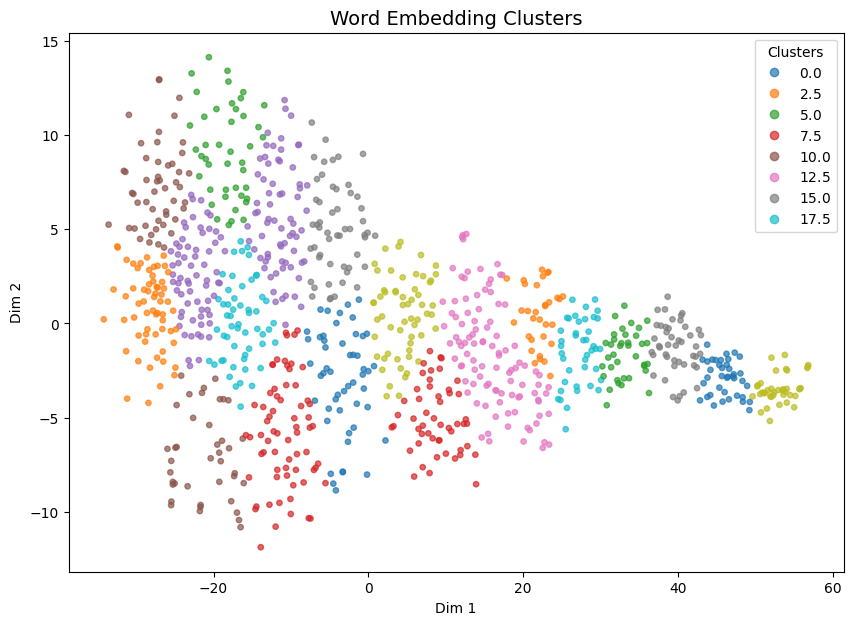

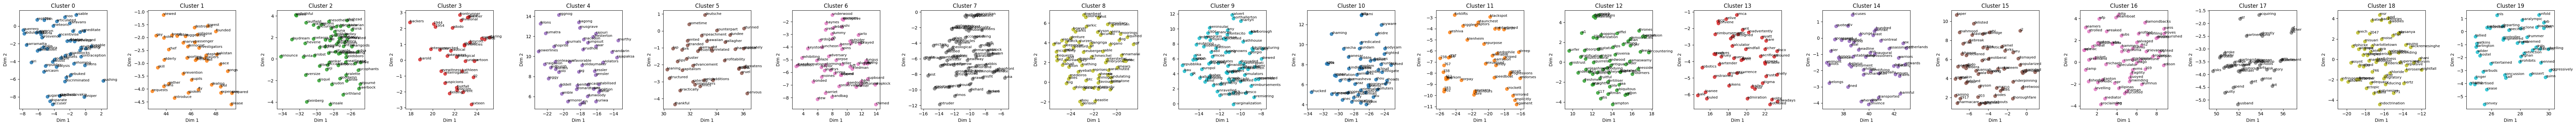

In [ ]:
perform_clustering(embedding_table=reduced_X, itos=itos, vocab=vocab)

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip /content/wiki-news-300d-1M.vec.zip

--2025-08-22 05:17:35--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.118, 3.171.22.33, 3.171.22.68, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip.1’

wiki-news-300d-1M.v 100%[===================>] 650.22M   102MB/s    in 5.0s    

2025-08-22 05:17:40 (131 MB/s) - ‘wiki-news-300d-1M.vec.zip.1’ saved [681808098/681808098]

Archive:  /content/wiki-news-300d-1M.vec.zip
replace wiki-news-300d-1M.vec? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wiki-news-300d-1M.vec   yes




In [ ]:
!wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

--2025-08-22 05:29:29--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.118, 3.171.22.33, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 4503593528 (4.2G), 4337328095 (4.0G) remaining [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G   161MB/s    in 37s     

2025-08-22 05:30:06 (111 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]

tar: This does not look like a tar archive
tar: Skipping to next header
tar: Archive contains ‘\001\224\276\252gv<\b\212*\275\017’ where numeric off_t value expected
^C


In [ ]:
!gunzip /content/cc.en.300.bin.gz

In [ ]:
import fasttext
fasttext_model = fasttext.load_model("/content/cc.en.300.bin")

In [ ]:
evaluate_fasttext_embeddings(sim_lex=sim_lex_df, ft_model=fasttext_model)

Evaluating embeddings: 100%|██████████| 999/999 [00:00<00:00, 1464.27it/s]


SimLex999 and Fasttext consensus percentage: 55.55555555555556


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import random

def perform_clustering_fasttext(ft_model, vocab, sample_size: int = 1000, n_clusters: int = 20):
    sampled_words = np.random.choice(list(vocab), size=sample_size, replace=False)
    embeddings = np.array([ft_model.get_word_vector(word) for word in tqdm(sampled_words, desc="Fetching embeddings")])

    tsne = TSNE(n_components=2, init="random")
    reduced_X = tsne.fit_transform(embeddings)

    kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
    labels_sample = kmeans.fit_predict(reduced_X)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(reduced_X[:, 0], reduced_X[:, 1], c=labels_sample, cmap="tab10", s=15, alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title("FastText Word Embedding Clusters", fontsize=14)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()

    fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 4), squeeze=False)

    for cluster_id in range(n_clusters):
        ax = axes[0, cluster_id]
        cluster_points = reduced_X[labels_sample == cluster_id]
        cluster_words = [sampled_words[i] for i in range(len(sampled_words)) if labels_sample[i] == cluster_id]

        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], c=f"C{cluster_id}", s=50, alpha=0.8)
        for i, word in enumerate(cluster_words):
            ax.annotate(word, (cluster_points[i, 0], cluster_points[i, 1]), fontsize=8)

        ax.set_title(f"Cluster {cluster_id}", fontsize=12)
        ax.set_xlabel("Dim 1")
        ax.set_ylabel("Dim 2")

    plt.tight_layout()
    plt.show()

Fetching embeddings: 100%|██████████| 1000/1000 [00:00<00:00, 22412.65it/s]


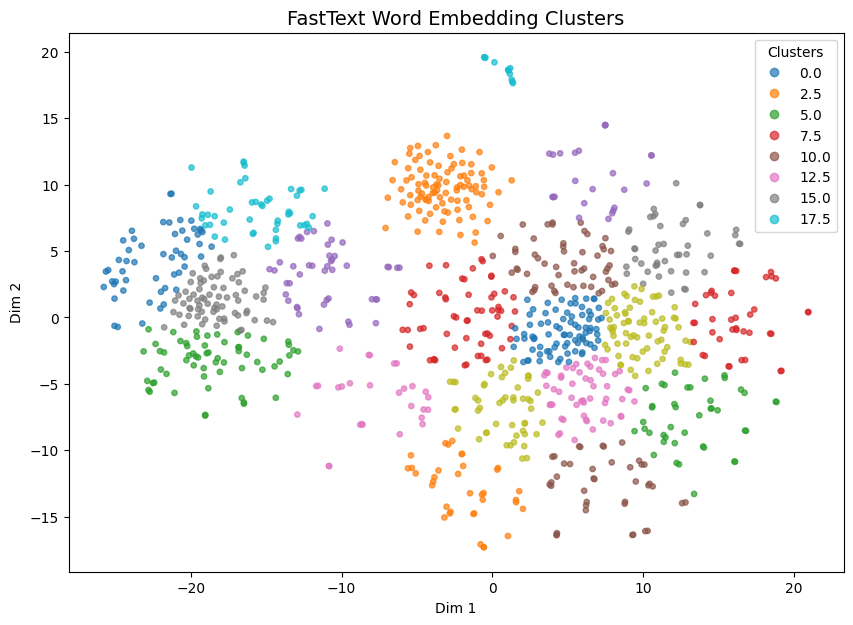

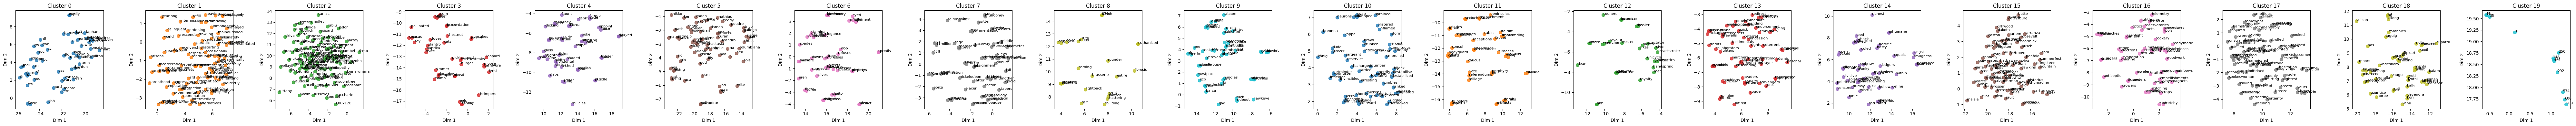

In [ ]:
perform_clustering_fasttext(ft_model=fasttext_model, vocab=vocab)